In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from itertools import product
sns.set_theme()
sns.set_style('whitegrid')

def get_raw_results(cur_dir, skip=0, till=-1, modifier=lambda x: x):
    with open(cur_dir, 'r') as file:
        elems = file.read().split('\n')[skip:till]
        elems = [modifier(float(e)) for e in elems]
        return elems

def results_generator(l, basedir, skip=0, till=-1, modifier=lambda x: x):
    for d in l:
        cur_dir = os.path.join(basedir, d)
        elems = get_raw_results(cur_dir, skip, till, modifier=modifier)
        m = sum(elems) / len(elems)
        yield m

In [3]:
def make_read_write_graph(ax, basedir, title, scalability=False, n_threads=1, rng=None, latency=False, show_caches=True, is_cpu=True, show_cpu=True, show_gpu=True, remote=False, far=False, skip=1, legend=True, cudamalloc=False, ms=3, labels=True, modifier=lambda x: x, transfer=False):
    if far:
        numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_far')]
    elif remote:
        numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_remote')]
    elif cudamalloc:
        numerical = [int(dir) for dir in os.listdir(basedir + '/cudamalloc')]
    elif transfer:
        numerical = [int(dir) for dir in os.listdir(basedir + '/pinned')]
    else:
        numerical = [int(dir) for dir in os.listdir(basedir + '/hbm')]
    numerical.sort()
    if rng is not None:
        numerical = numerical[rng[0]:rng[1]]
    #numerical = numerical[::2]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=skip, modifier=modifier))
    results2 = list(results_generator(l, basedir + '/hbm', skip=skip, modifier=modifier))
    if remote:
        results3 = list(results_generator(l, basedir + '/ddr_remote', skip=skip, modifier=modifier))
        results4 = list(results_generator(l, basedir + '/hbm_remote', skip=skip, modifier=modifier))
    if cudamalloc:
        results5 = list(results_generator(l, basedir + '/cudamalloc', skip=skip, modifier=modifier))
    if far:
        results6 = list(results_generator(l, basedir + '/ddr_far', skip=skip, modifier=modifier))
        results7 = list(results_generator(l, basedir + '/hbm_far', skip=skip, modifier=modifier))
    if transfer:
        results3 = list(results_generator(l, basedir + '/managed', skip=skip, modifier=modifier))
        results4 = list(results_generator(l, basedir + '/pinned', skip=skip, modifier=modifier))


    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if labels:
        if scalability:
            if is_cpu:
                ax.set_xlabel('Number of threads')
            else:
                ax.set_xlabel('Number of blocks')
        else:
            ax.set_xlabel('Buffer Size (bytes)')
        if latency:
            ax.set_ylabel('Latency (ns)')
        else:
            ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', ms=ms, label='DDR')
    ax.plot(numerical, results2, 'x', ms=ms, label='HBM')
    if remote:
        ax.plot(numerical, results3, 's', ms=ms, label='DDR-r')
        ax.plot(numerical, results4, '^', ms=ms, label='HBM-r')
    if cudamalloc:
        ax.plot(numerical, results5, '1', ms=ms, label='cudaMalloc')
    if far:
        ax.plot(numerical, results6, '2', ms=ms, label='DDR Far')
        ax.plot(numerical, results7, '3', ms=ms, label='HBM Far')
    if transfer:
        ax.plot(numerical, results3, 's', ms=ms, label='Managed')
        ax.plot(numerical, results4, '^', ms=ms, label='Pinned')
    #ax.plot(numerical, results3, '.', label='MMIO')
    if not scalability and show_caches:
        if show_cpu:
            if n_threads > 1:
                ax.axvline(x=65536*n_threads, linestyle=(0, (1, 10)), label = f'CPU L1 x {n_threads}')
                ax.axvline(x=1048576*n_threads, linestyle=(0, (3, 10, 1, 10)), label = f'CPU L2 x {n_threads}')
            ax.axvline(x=65536, ls=':', label = f'CPU L1')
            ax.axvline(x=1048576, ls='-.', label = f'CPU L2')
            ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        if show_gpu:
            ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
            ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    if legend:
        ax.legend(title='Memory type', fontsize=6, fo).get_title().set_fontsize('6')

def make_copy_graph(ax, basedir, title, scalability=False, show_caches=True, ms=3, legend=True, is_cpu=True):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_ddr')]
    numerical.sort()
    numerical = numerical[::]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr_ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm_hbm', skip=1))
    results3 = list(results_generator(l, basedir + '/hbm_ddr', skip=1))
    results4 = list(results_generator(l, basedir + '/ddr_hbm', skip=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        if is_cpu:
            ax.set_xlabel('Number of threads')
        else:
            ax.set_xlabel('Number of blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', ms=ms, label='DDR->DDR')
    ax.plot(numerical, results2, 'x', ms=ms, label='HBM->HBM')
    ax.plot(numerical, results3, 's', ms=ms, label='HBM->DDR')
    ax.plot(numerical, results4, '^', ms=ms, label='DDR->HBM')
    if not scalability and show_caches:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    if legend:
        ax.legend(title='', fontsize=6)

SyntaxError: positional argument follows keyword argument (113327731.py, line 76)

host ddr read max 403.5638484848482
host hbm read max 238.3593939393939
host ddr_remote read max 60.87886262626263
host hbm_remote read max 58.83237070707069
host ddr write max 463.7800101010099
host hbm write max 287.15375757575765
host ddr_remote write max 70.87195757575756
host hbm_remote write max 70.11547171717173
device ddr read max 420.2317878787878
device hbm read max 3795.8537373737377
device ddr_remote read max 83.8522191919192
device hbm_remote read max 125.61474747474747
device ddr write max 380.1491616161616
device hbm write max 3712.128686868688
device ddr_remote write max 81.91137474747477
device hbm_remote write max 124.48798989898988


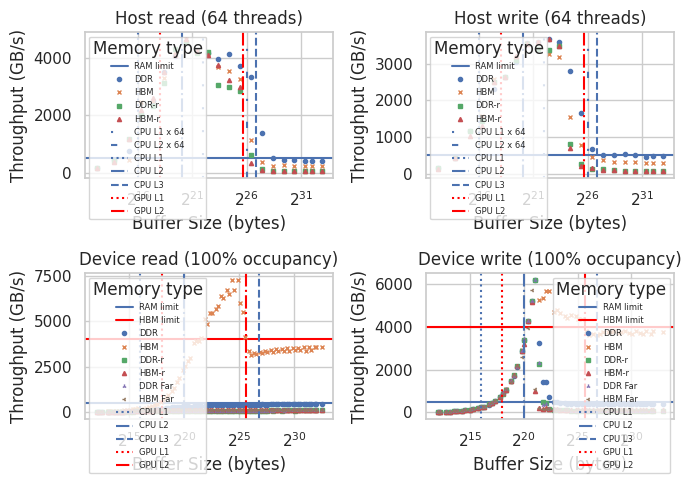

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,5), dpi=100)
ax1.axhline(y=500, label='RAM limit')
make_read_write_graph(ax1, 'results/read/host', 'Host read (64 threads)', False, 64, remote=True)
ax2.axhline(y=500, label='RAM limit')
make_read_write_graph(ax2, 'results/write/host', 'Host write (64 threads)', False, 64, remote=True)
ax3.axhline(y=500, label='RAM limit')
ax3.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax3, 'results/read/device', 'Device read (100% occupancy)', remote=True, far=True)
ax4.axhline(y=500, label='RAM limit')
ax4.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax4, 'results/write/device', 'Device write (100% occupancy)', remote=True, far=True)
plt.tight_layout()

#getting maxes
host_reads = list(results_generator([str(2**33)], 'results/read/host/ddr', skip=1))
print(f'host ddr read max {host_reads[0]}')
host_reads = list(results_generator([str(2**33)], 'results/read/host/hbm', skip=1))
print(f'host hbm read max {host_reads[0]}')
host_reads = list(results_generator([str(2**33)], 'results/read/host/ddr_remote', skip=1))
print(f'host ddr_remote read max {host_reads[0]}')
host_reads = list(results_generator([str(2**33)], 'results/read/host/hbm_remote', skip=1))
print(f'host hbm_remote read max {host_reads[0]}')

host_writes = list(results_generator([str(2**33)], 'results/write/host/ddr', skip=1))
print(f'host ddr write max {host_writes[0]}')
host_writes = list(results_generator([str(2**33)], 'results/write/host/hbm', skip=1))
print(f'host hbm write max {host_writes[0]}')
host_writes = list(results_generator([str(2**33)], 'results/write/host/ddr_remote', skip=1))
print(f'host ddr_remote write max {host_writes[0]}')
host_writes = list(results_generator([str(2**33)], 'results/write/host/hbm_remote', skip=1))
print(f'host hbm_remote write max {host_writes[0]}')

device_reads = list(results_generator([str(2**33)], 'results/read/device/ddr', skip=1))
print(f'device ddr read max {device_reads[0]}')
device_reads = list(results_generator([str(2**33)], 'results/read/device/hbm', skip=1))
print(f'device hbm read max {device_reads[0]}')
device_reads = list(results_generator([str(2**33)], 'results/read/device/ddr_remote', skip=1))
print(f'device ddr_remote read max {device_reads[0]}')
device_reads = list(results_generator([str(2**33)], 'results/read/device/hbm_remote', skip=1))
print(f'device hbm_remote read max {device_reads[0]}')
device_writes = list(results_generator([str(2**33)], 'results/write/device/ddr', skip=1))
print(f'device ddr write max {device_writes[0]}')
device_writes = list(results_generator([str(2**33)], 'results/write/device/hbm', skip=1))
print(f'device hbm write max {device_writes[0]}')
device_writes = list(results_generator([str(2**33)], 'results/write/device/ddr_remote', skip=1))
print(f'device ddr_remote write max {device_writes[0]}')
device_writes = list(results_generator([str(2**33)], 'results/write/device/hbm_remote', skip=1))
print(f'device hbm_remote write max {device_writes[0]}')

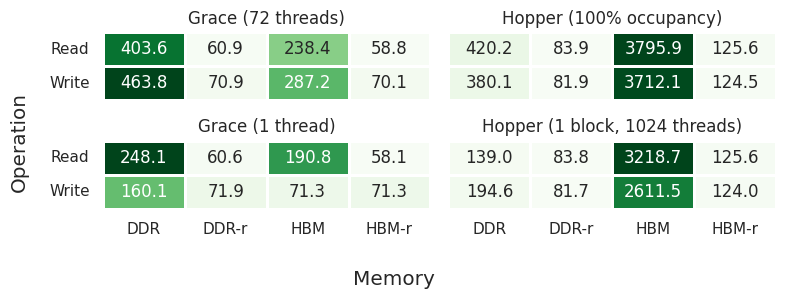

In [ ]:
mem_types = ['ddr', 'ddr_remote', 'hbm', 'hbm_remote']
mem_names = ['DDR', 'DDR-r', 'HBM', 'HBM-r']
ops = ['read', 'write']
ylabels = ['Read', 'Write']


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 3))

def plot_heatmap(ax, d, title, xlabels=[], ylabels=[]):
    data = np.zeros((len(ops), len(mem_types)))
    from itertools import product
    for (i, o), (j, m) in product(enumerate(ops), enumerate(mem_types)):
        data[i, j] = list(results_generator([str(2**33)], f'results/{o}/{d}/{m}', skip=1))[0]

    sns.heatmap(data, annot=True, fmt='.1f', xticklabels=xlabels, yticklabels=ylabels, linewidths=1, square=False, cmap='Greens', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plot_heatmap(ax1, 'host', 'Grace (72 threads)', ylabels=ylabels)
plot_heatmap(ax2, 'device', 'Hopper (100% occupancy)')
plot_heatmap(ax3, 'host/single', 'Grace (1 thread)', xlabels=mem_names, ylabels=ylabels)
plot_heatmap(ax4, 'device/block', 'Hopper (1 block, 1024 threads)', xlabels=mem_names)

fig.supxlabel("Memory")
fig.supylabel("Operation")
plt.tight_layout()
plt.savefig("read_write.pdf", bbox_inches='tight')

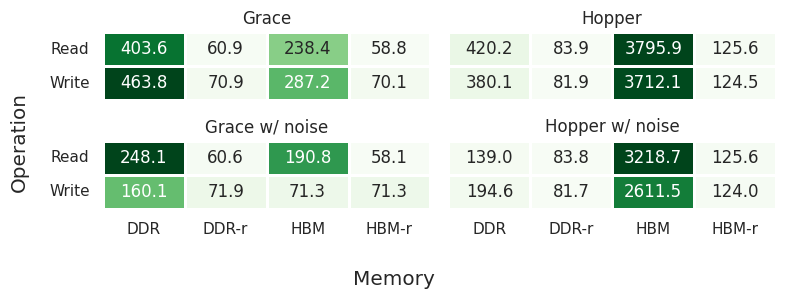

In [ ]:
mem_types = ['ddr', 'ddr_remote', 'hbm', 'hbm_remote']
mem_names = ['DDR', 'DDR-r', 'HBM', 'HBM-r']
ops = ['read', 'write']
ylabels = ['Read', 'Write']


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 3))

def plot_heatmap(ax, d, title, xlabels=[], ylabels=[]):
    data = np.zeros((len(ops), len(mem_types)))
    from itertools import product
    for (i, o), (j, m) in product(enumerate(ops), enumerate(mem_types)):
        data[i, j] = list(results_generator([str(2**33)], f'results/{o}/{d}/{m}', skip=1))[0]

    sns.heatmap(data, annot=True, fmt='.1f', xticklabels=xlabels, yticklabels=ylabels, linewidths=1, square=False, cmap='Greens', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plot_heatmap(ax1, 'host', 'Grace', ylabels=ylabels)
plot_heatmap(ax2, 'device', 'Hopper')
plot_heatmap(ax3, 'host/noisy', 'Grace w/ noise', xlabels=mem_names, ylabels=ylabels)
plot_heatmap(ax4, 'device/noisy', 'Hopper w/ noise', xlabels=mem_names)

fig.supxlabel("Memory")
fig.supylabel("Operation")
plt.tight_layout()
plt.savefig("read_write_noise.pdf", bbox_inches='tight')

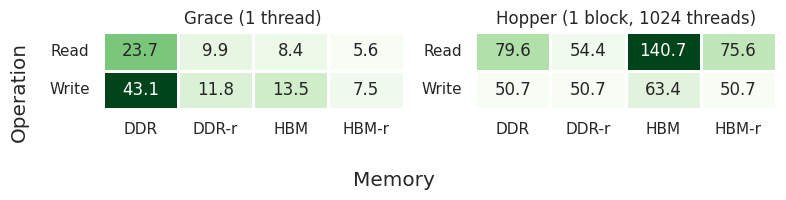

In [ ]:
mem_types = ['ddr', 'ddr_remote', 'hbm', 'hbm_remote']
mem_names = ['DDR', 'DDR-r', 'HBM', 'HBM-r']
ops = ['read', 'write']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))

def plot_heatmap(ax, d, title, ylabel="Operation"):
    data = np.zeros((len(ops), len(mem_types)))
    from itertools import product
    for (i, o), (j, m) in product(enumerate(ops), enumerate(mem_types)):
        try:
            data[i, j] = list(results_generator([str(2**33)], f'results/{o}/{d}/{m}', skip=1))[0]
        except:
            pass

    sns.heatmap(data, annot=True, fmt='.1f', xticklabels=mem_names, yticklabels=['Read', 'Write'], linewidths=1, square=False, cmap='Greens', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plot_heatmap(ax1, 'host/single', 'Grace (1 thread)')
plot_heatmap(ax2, 'device/block', 'Hopper (1 block, 1024 threads)')

fig.supxlabel("Memory")
fig.supylabel("Operation")
plt.tight_layout()
plt.savefig("read_write_single.pdf", bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'results/read/host/single/ddr/4294967296'

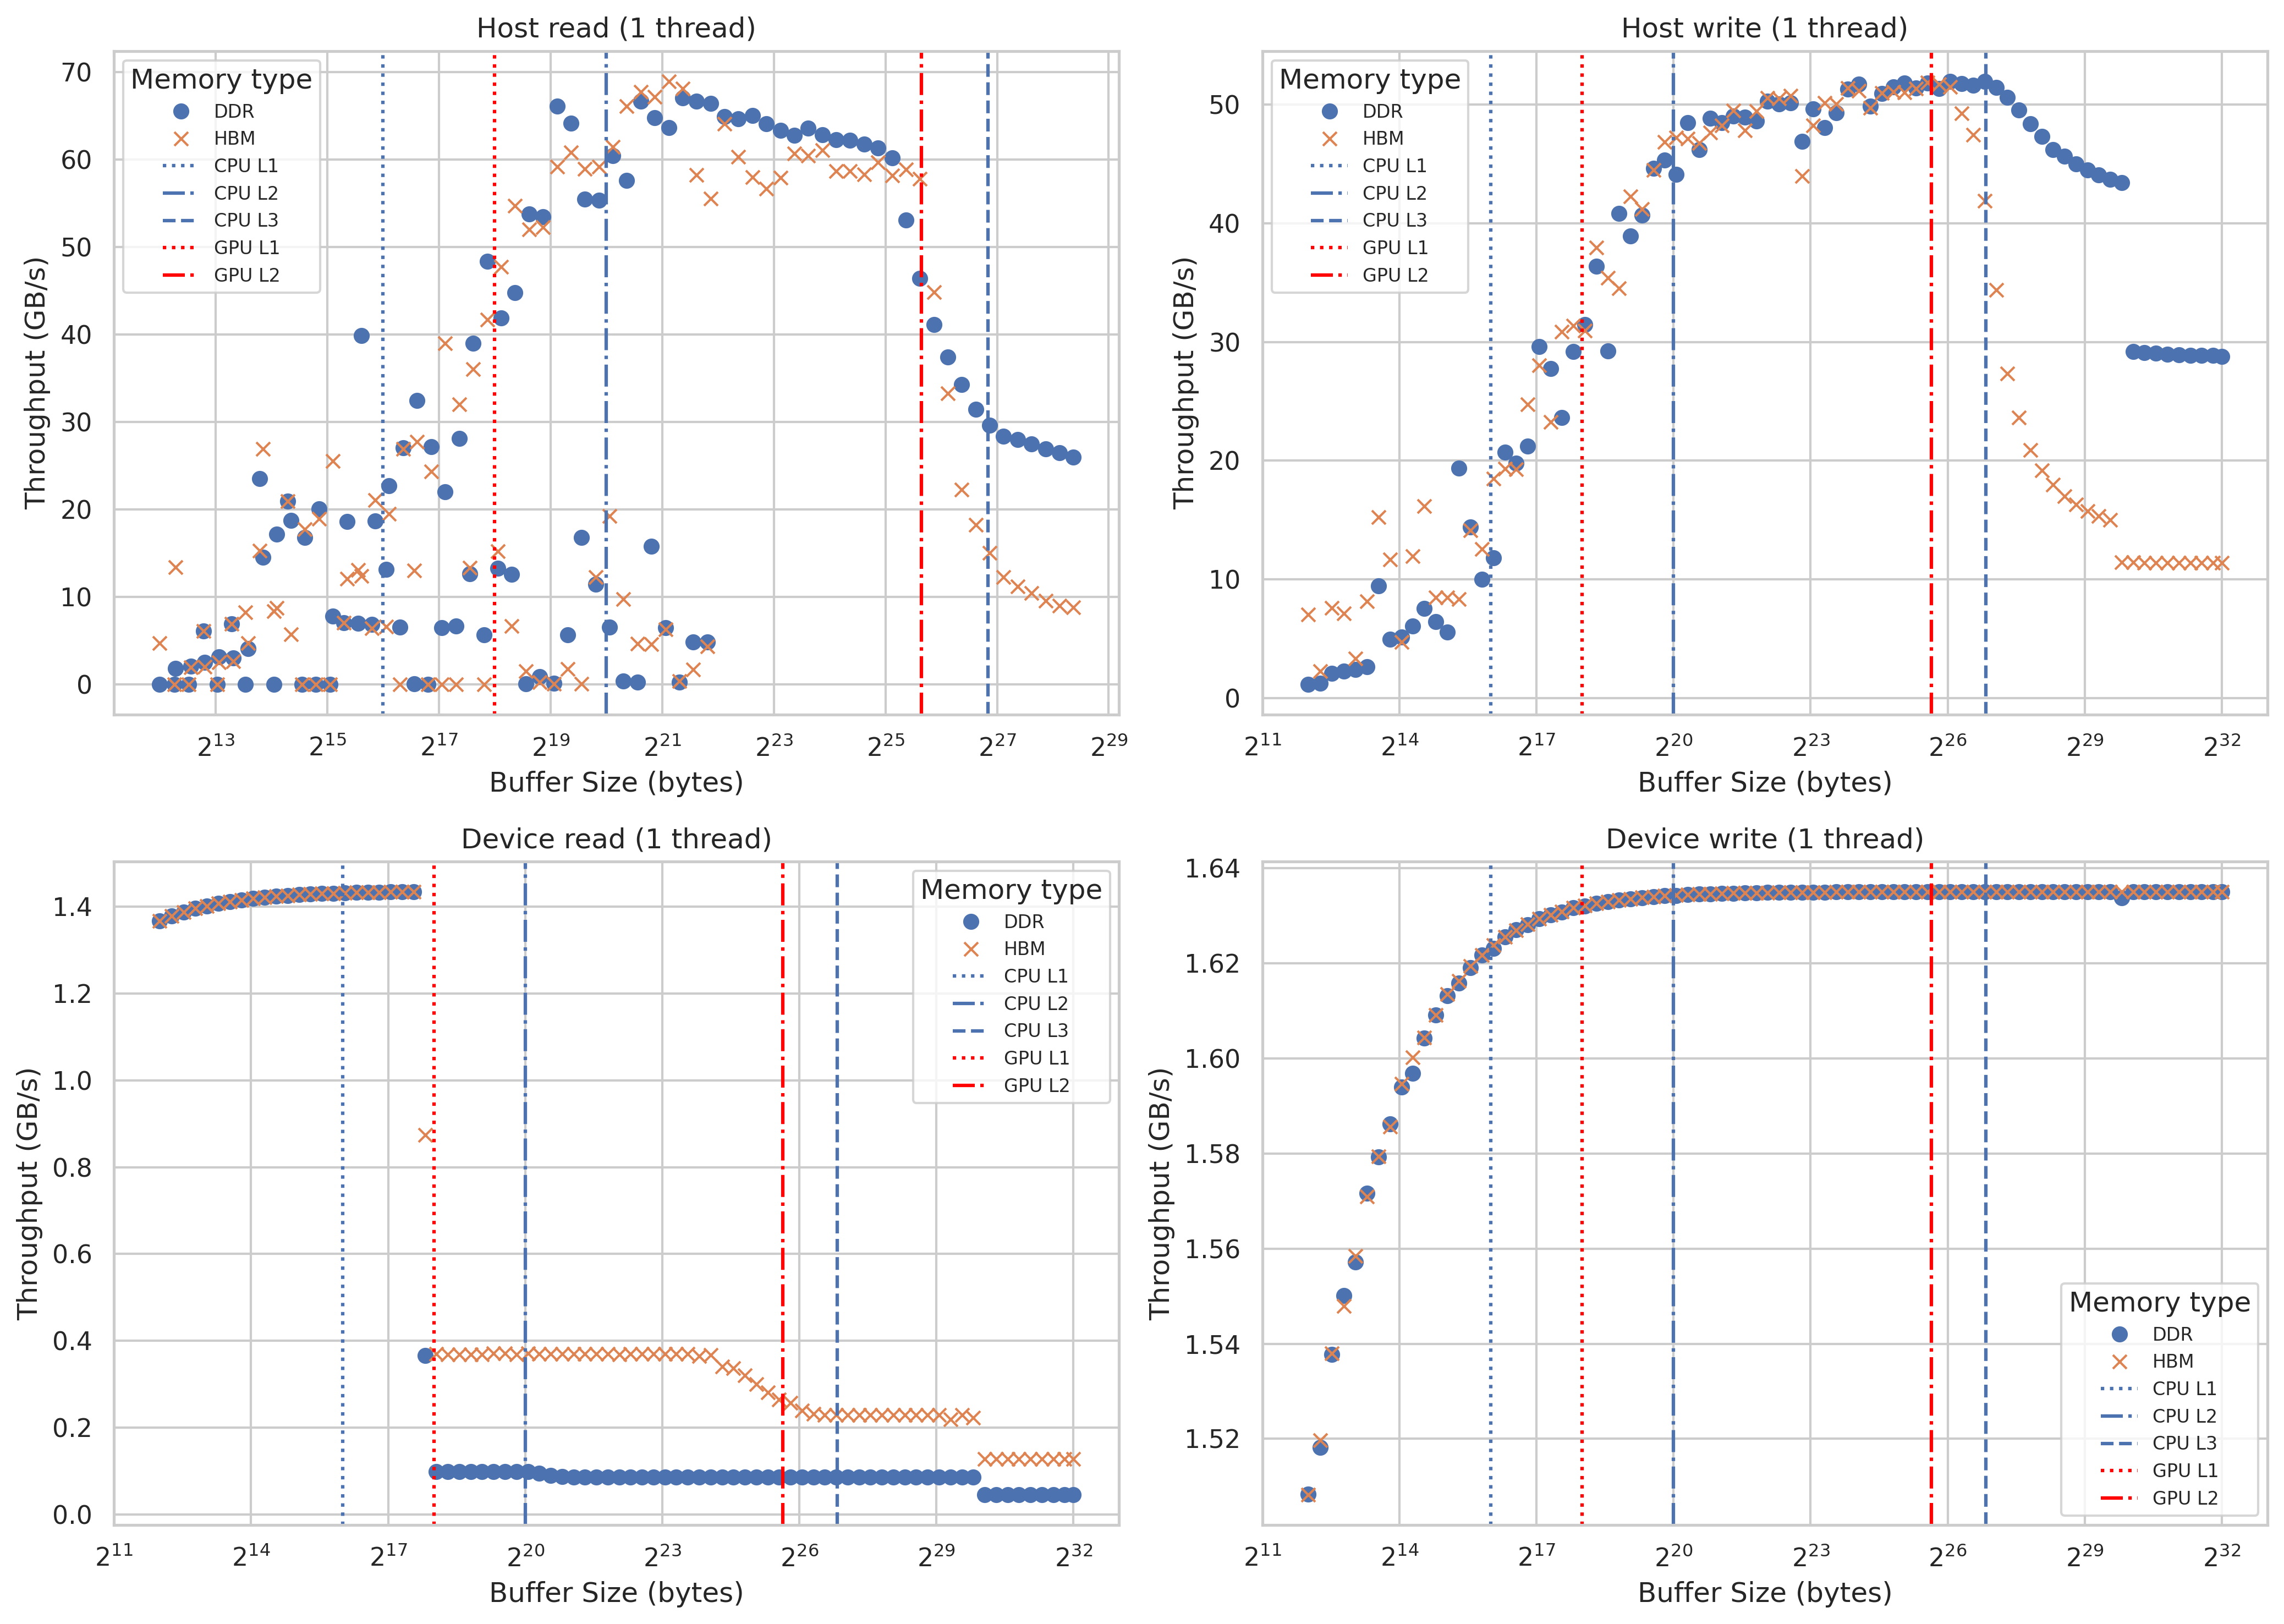

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
make_read_write_graph(ax1, 'results/read/host/single', 'Host read (1 thread)')
make_read_write_graph(ax2, 'results/write/host/single', 'Host write (1 thread)')
make_read_write_graph(ax3, 'results/read/device/single', 'Device read (1 thread)')
make_read_write_graph(ax4, 'results/write/device/single', 'Device write (1 thread)')
fig.set_dpi(300)
plt.tight_layout()

#getting maxes
host_reads = list(results_generator([str(2**32)], 'results/read/host/single/ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr read max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/read/host/single/hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm read max {host_reads[0]}')

device_reads = list(results_generator([str(395303808)], 'results/read/device/single/ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr read max {device_reads[0]}')
device_reads = list(results_generator([str(395303808)], 'results/read/device/single/hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm read max {device_reads[0]}')
device_writes = list(results_generator([str(2**32)], 'results/write/device/single/ddr', skip=1))
device_writes_argmax = np.argmax(device_writes)
print(f'device ddr write max {device_writes[0]}')
device_writes = list(results_generator([str(2**32)], 'results/write/device/single/hbm', skip=1))
device_writes_argmax = np.argmax(device_writes)
print(f'device hbm write max {device_writes[0]}')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,5))
ax1.axhline(y=450, color='green', label='NVlink limit')
ax1.axhline(y=500, label='RAM limit')
make_copy_graph(ax1, 'results/copy/host', 'Host copy (64 threads)')
ax2.axhline(y=450, color='green', label='NVlink limit')
ax2.axhline(y=500, label='RAM limit')
# ax2.axhline(y=4000, color='red', label='HBM limit')
make_copy_graph(ax2, 'results/copy/device', 'Device copy (100% occupancy)')
make_copy_graph(ax3, 'results/copy/host/single', 'Host copy (1 thread)')
make_copy_graph(ax4, 'results/copy/device/single', 'Device copy (1 thread)')
plt.tight_layout()

#getting maxes
device_reads = list(results_generator([str(2**32)], 'results/copy/device/ddr_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/hbm_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_hbm copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/hbm_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/ddr_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_hbm copy max {device_reads[0]}')

device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/ddr_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/hbm_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_hbm copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/hbm_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/ddr_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_hbm copy max {device_reads[0]}')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,12))
ax1.axhline(y=500, label='RAM limit')
make_read_write_graph(ax1, 'results/memset/host', 'Host memset (64 threads)', False, 64)
ax2.axhline(y=500, label='RAM limit')
make_copy_graph(ax2, 'results/memcpy/host', 'Host memcpy (64 threads)')
make_read_write_graph(ax3, 'results/memset/host/single', 'Host memset (1 thread)')
make_copy_graph(ax4, 'results/memcpy/host/single', 'Host memcpy (1 thread)')
ax5.axhline(y=500, label='RAM limit')
make_read_write_graph(ax5, 'results/memset/host/scalability', 'Host memset', True)
make_copy_graph(ax6, 'results/memcpy/host/scalability', 'Host memcpy', True)
plt.tight_layout()

#getting maxes
host_reads = list(results_generator([str(2**32)], 'results/memset/host/ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr memset max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memset/host/hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm memset max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memset/host/single/ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr memset max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memset/host/single/hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm memset max {host_reads[0]}')

l = list(str(i) for i in range(1, 65))
host_writes = list(results_generator(l, 'results/memset/host/scalability/ddr', skip=1))
am = np.argmax(host_writes)
print(f'host ddr write max {host_writes[am]} ({am+1} threads)')
host_writes = list(results_generator(l, 'results/memset/host/scalability/hbm', skip=1))
am = np.argmax(host_writes)
print(f'host hbm write max {host_writes[am]} ({am+1} threads)')

host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/ddr_ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr_ddr memcpy max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/hbm_hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm_hbm memcpy max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/hbm_ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm_ddr memcpy max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/ddr_hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr_hbm memcpy max {host_reads[0]}')

host_copies = list(results_generator(l, 'results/memcpy/host/scalability/ddr_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/memcpy/host/scalability/hbm_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->hbm copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/memcpy/host/scalability/hbm_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/memcpy/host/scalability/ddr_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->hbm copy max {host_copies[am]} ({am+1} threads)')

DDR 32.52545
HBM 98.29925
DDR-p 84.8747
HBM-p 149.2275
DDR 817.81476
HBM 344.23136999999997
DDR-p 1213.6086999999998
HBM-p 1022.9188999999999


/tmp/ipykernel_7093/1088348734.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
/tmp/ipykernel_7093/1088348734.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)


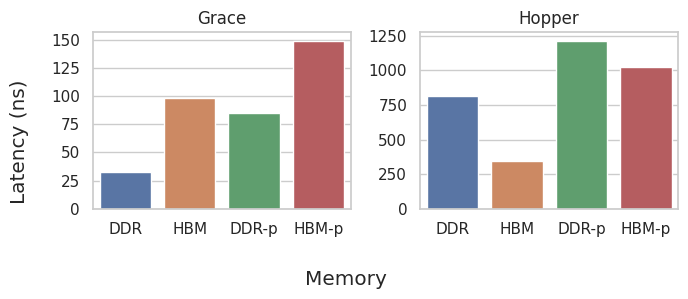

In [ ]:
# experiments_cpu = ['fine/host/ddr', 'fine/host/ddr_remote', 'fine/host/hbm', 'fine/host/hbm_remote']
# experiments_gpu = ['fine/device/ddr', 'fine/device/hbm_remote', 'fine/device/hbm', 'fine/device/ddr_remote']
# labels = ['DDR', 'DDR-r', 'HBM', 'HBM-r']
experiments_cpu = ['fine/host/ddr', 'fine/host/hbm', 'fine/host/ddr_remote', 'fine/host/hbm_remote']
experiments_gpu = ['fine/device/ddr', 'fine/device/hbm', 'fine/device/ddr_remote', 'fine/device/hbm_remote']
labels = ['DDR', 'HBM', 'DDR-p', 'HBM-p']
data1 = {}
data2 = {}

for e, l in zip(experiments_cpu, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[:-1]
        elems = [float(e) for e in elems]
        elems.sort()
        # elems = elems[5:-5]
        data1[l] = elems

for e, l in zip(experiments_gpu, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[:-1]
        elems = [float(e) for e in elems]
        data2[l] = elems

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.set_title('Grace')
ax2.set_title('Hopper')
# ax1.set_ylabel('Latency (ns)')
#ax2.set_ylabel('Latency (ns)')
sns.barplot(data1, ax=ax1)
sns.barplot(data2, ax=ax2)
ax1.set_yticks(range(0, 151, 25))
ax2.set_yticks(range(0, 1251, 250))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
fig.supxlabel("Memory")
fig.supylabel("Latency (ns)")
plt.tight_layout()
fig.savefig("latency.pdf", bbox_inches='tight')

for k, v in data1.items():
    print(k, np.mean(v))
for k, v in data2.items():
    print(k, np.mean(v))

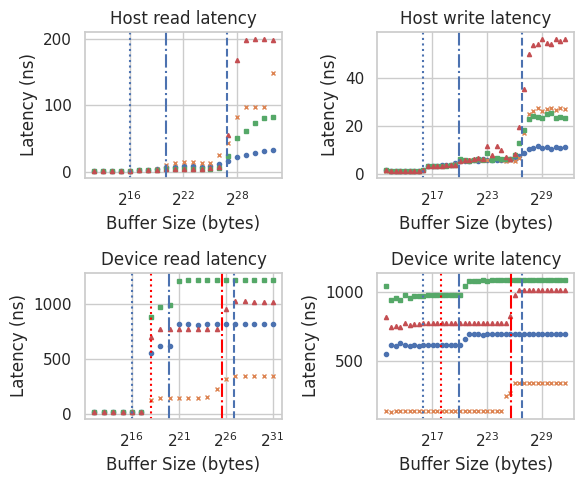

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,5))
make_read_write_graph(ax1, 'results/latency/host/scalability', 'Host read latency', latency=True, show_gpu=False, remote=True, legend=False)
make_read_write_graph(ax2, 'results/latency/host/scalability/write/', 'Host write latency', latency=True, show_gpu=False, remote=True, legend=False)
make_read_write_graph(ax3, 'results/latency/device/scalability', 'Device read latency', latency=True, show_cpu=True, remote=True, legend=False)
make_read_write_graph(ax4, 'results/latency/device/scalability/write/', 'Device write latency', latency=True, show_cpu=True, remote=True, legend=False)
#ax4.legend(title='Memory type', framealpha=1.0)
plt.tight_layout()

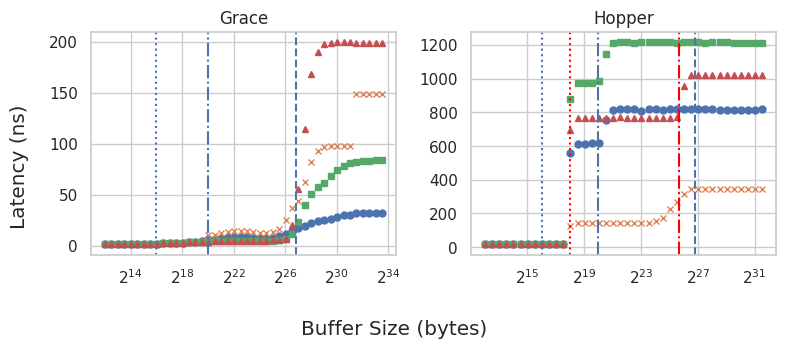

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3.5))
make_read_write_graph(ax1, 'results/latency/host/scalability', 'Grace', latency=True, show_gpu=False, remote=True, legend=False, ms=5, labels=False)
make_read_write_graph(ax2, 'results/latency/device/scalability', 'Hopper', latency=True, show_cpu=True, remote=True, legend=False, ms=5, labels=False)
#ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.61), fontsize=8)
#ax4.legend(title='Memory type', framealpha=1.0)
fig.set_dpi(100)
fig.supxlabel("Buffer Size (bytes)")
fig.supylabel("Latency (ns)")
plt.tight_layout()
fig.savefig("latency_scalability.pdf", bbox_inches='tight')

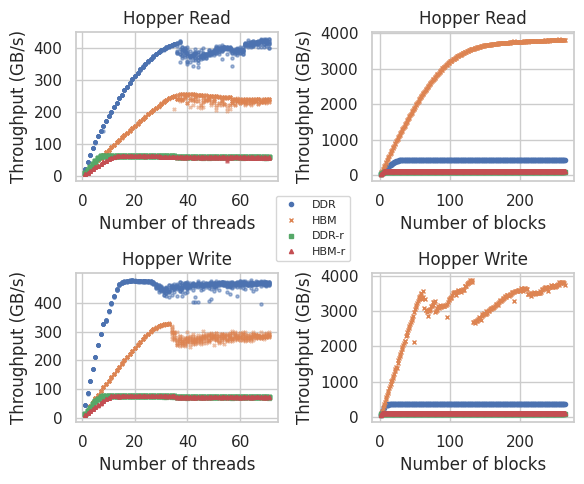

In [ ]:
experiments_cpu = ['ddr', 'hbm', 'ddr_remote', 'hbm_remote']
styles = ['o', 'x', 's', '^']
labels = ['DDR', 'DDR-r', 'HBM', 'HBM-r']
x = [i for i in range(1, 72) for _ in range(9)]
ops = ['read', 'write']

def myplot(axes):
    for o, ax in zip(ops, axes):
        for e, s in zip(experiments_cpu, styles):
            data = []
            for i in range(1, 72):
                with open(f'results/{o}/host/scalability/{e}/{i}', 'r') as file:
                    elems = file.read().split('\n')[1:-1]
                    elems = [float(e) for e in elems]
                    data += elems
            ax.scatter(x, data, marker=s, s=5, alpha=0.5)
            if o == 'read':
                ax.set_title('Hopper Read')
            else:
                ax.set_title('Hopper Write')
            ax.set_xlabel('Number of threads')
            ax.set_ylabel('Throughput (GB/s)')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,5))
# ax4.axvline(x=65, ls=':', label = f'65')
# ax4.axvline(x=129, ls=':', label = f'129')
# ax4.axvline(x=233, ls=':', label = f'233')
# ax4.axvline(x=257, ls=':', label = f'257')
# ax6.axvline(x=65, ls=':', label = f'65')
# ax6.axvline(x=129, ls=':', label = f'129')
# ax1.axhline(y=500, label='RAM limit')
# ax2.axhline(y=500, label='RAM limit')
# ax3.axhline(y=250, label='Half RAM limit')
# make_read_write_graph(ax1, 'results/read/host/scalability', 'Grace Read', True, remote=True, legend=False)
# make_read_write_graph(ax3, 'results/write/host/scalability', 'Grace Write', True, remote=True, legend=False)
myplot([ax1, ax3])
ax1.set_yticks([0,100,200,300,400])
ax3.set_yticks([0,100,200,300,400])
# make_copy_graph(ax3, 'results/copy/host/scalability', 'Host copy', True)
make_read_write_graph(ax2, 'results/read/device/scalability', 'Hopper Read', True, remote=True, legend=False, is_cpu=False)
make_read_write_graph(ax4, 'results/write/device/scalability', 'Hopper Write', True, remote=True, legend=False, is_cpu=False)
ax2.set_yticks([0,1000,2000,3000,4000])
ax4.set_yticks([0,1000,2000,3000,4000])
# make_copy_graph(ax6, 'results/copy/device/scalability', 'Device copy', True)
plt.tight_layout()
ax4.legend(loc='center left', bbox_to_anchor=(-0.5, 1.3), fontsize=8)
fig.savefig("read_write_scalability.pdf", bbox_inches='tight')

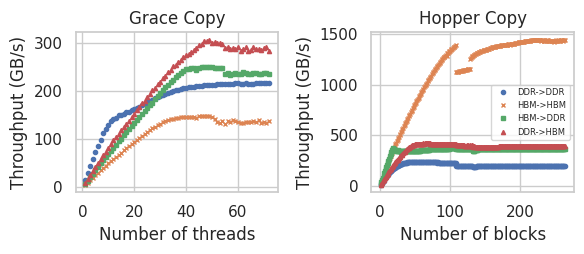

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.7))
make_copy_graph(ax1, 'results/copy/host/scalability', 'Grace Copy', True, legend=False)
make_copy_graph(ax2, 'results/copy/device/scalability', 'Hopper Copy', True, legend=True, is_cpu=False)
# ax1.set_yticks([0,100,200,300,400])
# ax2.set_yticks([0,100,200,300,400])
plt.tight_layout()
fig.savefig("copy_scalability.pdf", bbox_inches='tight')

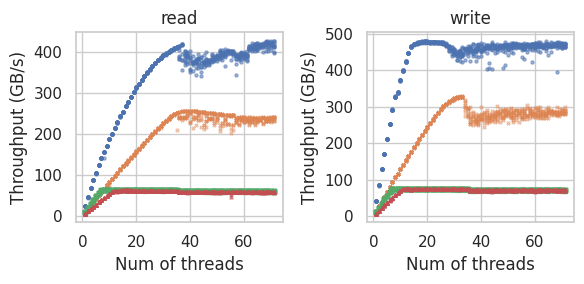

In [ ]:
experiments_cpu = ['ddr', 'hbm', 'ddr_remote', 'hbm_remote']
styles = ['o', 'x', 's', '^']
labels = ['DDR', 'DDR-r', 'HBM', 'HBM-r']
x = [i for i in range(1, 72) for _ in range(9)]
ops = ['read', 'write']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for o, ax in zip(ops, axes):
    df = None
    for e, s in zip(experiments_cpu, styles):
        data = []
        for i in range(1, 72):
            with open(f'results/{o}/host/scalability/{e}/{i}', 'r') as file:
                elems = file.read().split('\n')[1:-1]
                elems = [float(e) for e in elems]
                data += elems
        ax.scatter(x, data, marker=s, s=5, alpha=0.5)
        # ax.plot(x, data, s, ms=3, alpha=0.5)
        # if df is None:
        #     df = pd.DataFrame({'x': x, 'y': data, 'style': [e]*len(x)})
        # else:
        #     df = pd.concat([df, pd.DataFrame({'x': x, 'y': data, 'style': [e]*len(x)})])
    # sns.lineplot(df, x='x', y='y', hue="style", style="style", errorbar=('pi', 99), ax=ax, markers=['o','X','s','^'], legend=False)
    ax.set_title(o)
    ax.set_xlabel('Num of threads')
    ax.set_ylabel('Throughput (GB/s)')

plt.tight_layout()
fig.savefig("grace_write_hbm.pdf", bbox_inches='tight')

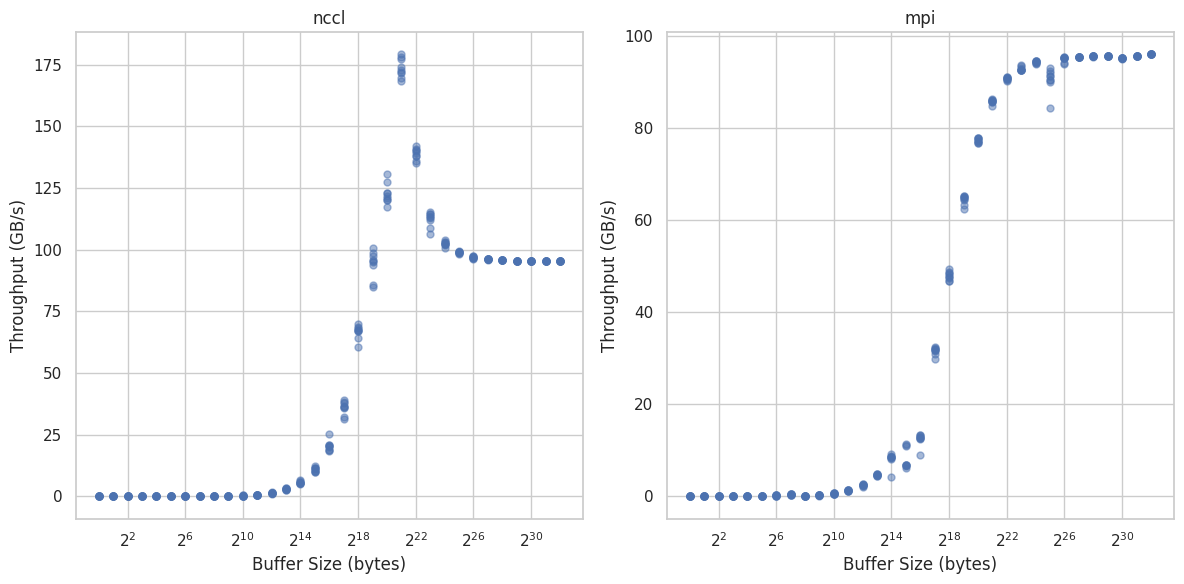

In [23]:
experiments_cpu = ['hbm_hbm']
styles = ['o', 'x', 's', '^']
labels = ['DDR->DDR', 'HBM->HBM', 'HBM', 'HBM-r']
i = 1
x = []
while i <= 2**32:
    for _ in range(9):
        x.append(i)
    i *= 2
ops = ['nccl', 'mpi']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for o, ax in zip(ops, axes):
    df = None
    for e, s in zip(experiments_cpu, styles):
        data = []
        for i in x[::9]:
            with open(f'results/nccl/group_send_recv/mono/{o}/4/{e}/{i}', 'r') as file:
                elems = file.read().split('\n')[1:-1]
                elems = [float(e) for e in elems]
                data += elems
        # ax.scatter(x, data, marker=s, s=5, alpha=0.5)
        ax.plot(x, data, s, ms=5, alpha=0.5)
        if df is None:
            df = pd.DataFrame({'x': x, 'y': data, 'style': [e]*len(x)})
        else:
            df = pd.concat([df, pd.DataFrame({'x': x, 'y': data, 'style': [e]*len(x)})])
    # sns.lineplot(df, x='x', y='y', hue="style", style="style", ax=ax, markers=['o','X','s','^'], legend=False)
    ax.set_title(o)
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Buffer Size (bytes)')
    ax.set_ylabel('Throughput (GB/s)')

plt.tight_layout()
fig.savefig("grace_write_hbm.pdf", bbox_inches='tight')

In [ ]:
#getting maxes
def pick_max_read_write(n_elem, path):
    l = list(str(elem) for elem in range(1,n_elem+1))
    reads = list(results_generator(l, 'results/read/' + path, skip=1))
    am_read = np.argmax(reads)
    writes = list(results_generator(l, 'results/write/' + path, skip=1))
    am_write = np.argmax(writes)

    return max(reads[am_read], writes[am_write])

def print_results(n_elem, basepath, device):
    for mem in ['ddr', 'hbm', 'ddr_remote', 'hbm_remote']:
        print(f'{device} {mem}', pick_max_read_write(n_elem, f'{basepath}/{mem}'))
    
print_results(64, 'host/scalability/', 'host')
print_results(264, 'device/scalability/', 'device')


host ddr 478.89677777777774
host hbm 327.9862222222222
host ddr_remote 75.41554444444445
host hbm_remote 75.1982111111111
device ddr 421.9866666666667
device hbm 3870.6155555555556
device ddr_remote 83.93043333333334
device hbm_remote 125.91333333333334


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.axhline(y=450, color='green', label='NVlink limit')
ax1.axhline(y=500, label='RAM limit')
ax1.axhline(y=4000, color='red', label='HBM limit')
ax2.axhline(y=450, color='green', label='NVlink limit')
ax2.axhline(y=500, label='RAM limit')
#ax2.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax1, 'results/write/device/throughput', 'Device write')
make_copy_graph(ax2, 'results/copy/device/throughput', 'Device copy')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.axvline(x=84_825_604_096, color='green', ls='--', label='HBM size')
ax2.axvline(x=84_825_604_096, color='green', ls='--', label='HBM size')
ax3.axvline(x=84_825_604_096, color='green', ls='--', label='HBM size')
make_read_write_graph(ax1, 'results/read/device/large', 'Device read', show_caches=False)
make_read_write_graph(ax2, 'results/write/device/large', 'Device write', show_caches=False)
make_copy_graph(ax3, 'results/copy/device/large', 'Device copy', show_caches=False)
plt.tight_layout()

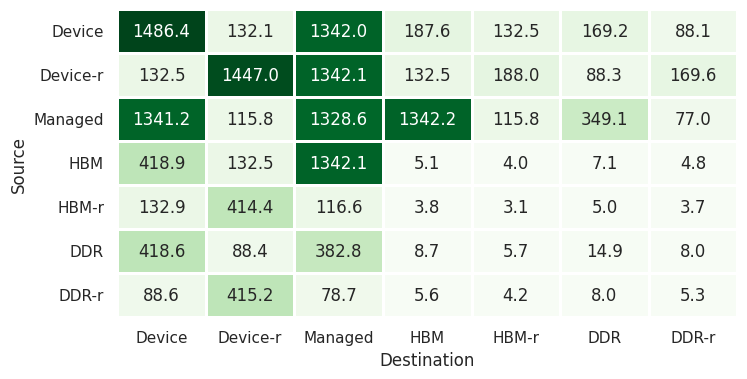

In [ ]:
mem_types = ['CMC', 'CMR', 'MGH', 'MMD', 'MDR', 'MMH', 'MHR']
mem_names = ['Device', 'Device-r', 'Managed', 'HBM', 'HBM-r', 'DDR', 'DDR-r']

mem_tuples = zip(mem_types, mem_names)

data = np.zeros((len(mem_types), len(mem_types)))

from itertools import product
for (i, a), (j, b) in product(enumerate(mem_types), enumerate(mem_types)):
    data[i, j] = np.mean(get_raw_results(f'results/memcpy/cuda/heatmap/{a}_{b}'))

plt.figure(figsize=(8, 4))
ax = sns.heatmap(data, annot=True, fmt='.1f', xticklabels=mem_names, yticklabels=mem_names, linewidths=1, square=False, cmap='Greens', cbar=False)
ax.set(xlabel="Destination", ylabel="Source")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.savefig("cudamemcpy.pdf", bbox_inches='tight')

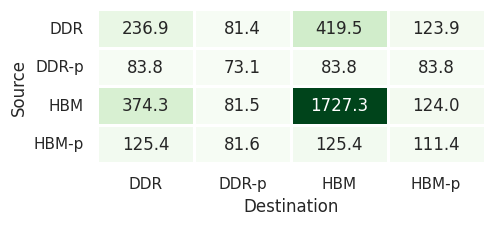

In [28]:
# mem_types = ['CMC', 'CMR', 'MGH', 'MMD', 'MDR', 'MMH', 'MHR']
# mem_names = ['Device', 'Device-r', 'Managed', 'HBM', 'HBM-r', 'DDR', 'DDR-r']

mem_types = ['MMH', 'MHR', 'MMD', 'MDR']
mem_names = ['DDR', 'DDR-p', 'HBM', 'HBM-p']

mem_tuples = zip(mem_types, mem_names)

data = np.zeros((len(mem_types), len(mem_types)))

from itertools import product
for (i, a), (j, b) in product(enumerate(mem_types), enumerate(mem_types)):
    data[i, j] = np.mean(get_raw_results(f'results/copy/device/heatmap/{a}_{b}'))

plt.figure(figsize=(5, 2))
ax = sns.heatmap(data, annot=True, fmt='.1f', xticklabels=mem_names, yticklabels=mem_names, linewidths=1, square=False, cmap='Greens', cbar=False)
ax.set(xlabel="Destination", ylabel="Source")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.savefig("device_copy.pdf", bbox_inches='tight')

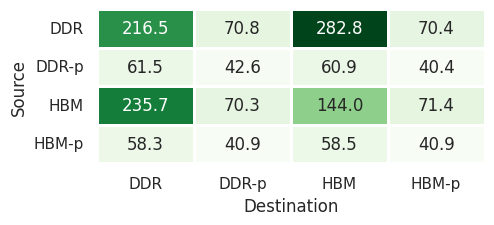

In [29]:
mem_types = ['MMH', 'MHR', 'MMD', 'MDR']
mem_names = ['DDR', 'DDR-p', 'HBM', 'HBM-p']

mem_tuples = zip(mem_types, mem_names)

data = np.zeros((len(mem_types), len(mem_types)))

from itertools import product
for (i, a), (j, b) in product(enumerate(mem_types), enumerate(mem_types)):
    data[i, j] = np.mean(get_raw_results(f'results/copy/host/heatmap/{a}_{b}'))

plt.figure(figsize=(5, 2))
ax = sns.heatmap(data, annot=True, fmt='.1f', xticklabels=mem_names, yticklabels=mem_names, linewidths=1, square=False, cmap='Greens', cbar=False)
ax.set(xlabel="Destination", ylabel="Source")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.savefig("host_copy.pdf", bbox_inches='tight')

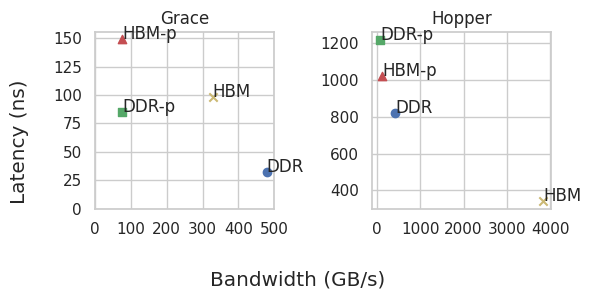

In [ ]:
from matplotlib.patches import FancyArrowPatch
from matplotlib.ticker import FuncFormatter, FixedLocator, LogLocator, ScalarFormatter
from math import sqrt
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(6, 3))
fig.set_dpi(100)


# labels = ['Grace-DDR', 'Grace-HBM', 'Hopper-DDR', 'Hopper-HBM', 'Grace-DDR-p', 'Grace-HBM-p', 'Hopper-DDR-p', 'Hopper-HBM-p']
# x = [478.89677777777774, 327.9862222222222, 421.9866666666667, 3834.6266666666666,
#     75.41554444444445, 75.1982111111111, 83.93043333333334, 125.91333333333334]
# y = [32.089544000000004, 83.72047700000002, 98.13605299999998, 149.23937999999998,
# 817.81476, 1022.9188999999999, 1213.6086999999998, 1022.9188999999999]

# DDR 32.52545
# HBM 98.29925
# DDR-p 84.8747
# HBM-p 149.2275
# DDR 817.81476
# HBM 344.23136999999997
# DDR-p 1213.6086999999998
# HBM-p 1022.9188999999999


labels = ['DDR', 'HBM', 'DDR-p', 'HBM-p']
x = [478.89677777777774, 327.9862222222222, 75.41554444444445, 75.1982111111111]
y = [32.52545, 98.29925, 84.8747, 149.2275]
markers = ['o', 'x', 's', '^']
colors = ['b', 'y', 'g', 'r']
# offsets = [(0, 0), (0, 40), (0, 0), (-950, 0), (0, 0), (0, 70), (0, 0), (0, 50)]

for i, c in enumerate(labels):
    xi = [x[j] for j in range(len(x)) if labels[j] == c]
    yi = [y[j] for j in range(len(y)) if labels[j] == c]
    ax.scatter(xi, yi, color=colors[i], marker=markers[i], label=c)
    for label, cur_x, cur_y in zip(labels, xi, yi):
        # ax.text(cur_x + 50 + offsets[i][0], cur_y + 10 + offsets[i][1], c)
        ax.text(cur_x, cur_y, c)

ax.set(title="Grace")

labels = ['DDR', 'HBM', 'DDR-p', 'HBM-p']
x = [421.9866666666667, 3834.6266666666666, 83.93043333333334, 125.91333333333334]
y = [817.81476, 344.23136999999997, 1213.60869999999987, 1022.9188999999999]

for i, c in enumerate(labels):
    xi = [x[j] for j in range(len(x)) if labels[j] == c]
    yi = [y[j] for j in range(len(y)) if labels[j] == c]
    ax2.scatter(xi, yi, color=colors[i], marker=markers[i], label=c)
    for label, cur_x, cur_y in zip(labels, xi, yi):
        # ax.text(cur_x + 50 + offsets[i][0], cur_y + 10 + offsets[i][1], c)
        ax2.text(cur_x, cur_y, c)
ax2.set(title="Hopper")
fig.supxlabel("Bandwidth (GB/s)")
fig.supylabel("Latency (ns)")

ax.set_xticks(range(0, 501, 100))
ax.set_yticks(range(0, 151, 25))
ax2.set_xticks(range(0, 4001, 1000))

plt.tight_layout()
plt.savefig("bandwidth_latency_plot.pdf", bbox_inches='tight')

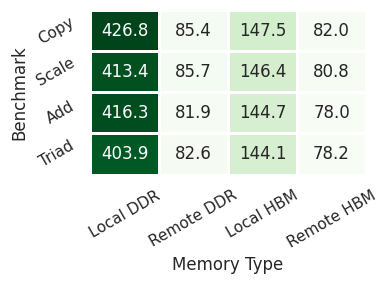

In [ ]:
labels_x = ['Local DDR', 'Remote DDR', 'Local HBM', 'Remote HBM']
labels_y = ['Copy', 'Scale', 'Add', 'Triad']

data = np.array([
    [426803.4, 413351.5, 416261.6, 403918.3],
    [85367.4, 85669.1, 81883.6, 82619.6],
    [147517.0, 146438.3, 144738.7, 144112.3],
    [81970.1, 80813.4, 77975.7, 78180.2]
]).T
data /= 1000




fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
sns.heatmap(data, ax=ax1, annot=True, fmt='.1f', xticklabels=labels_x, yticklabels=labels_y, linewidths=1, square=False, cmap='Greens', cbar=False)
ax1.set(xlabel="Memory Type", ylabel="Benchmark")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=30)
plt.tight_layout()
# fig, ax = plt.subplots(1, 1)
# ax.boxplot(data)
# # ax.set_yscale('log')
# ax.set_xticks([1, 2, 3, 4], labels_x)
fig.savefig("stream.pdf", bbox_inches='tight')

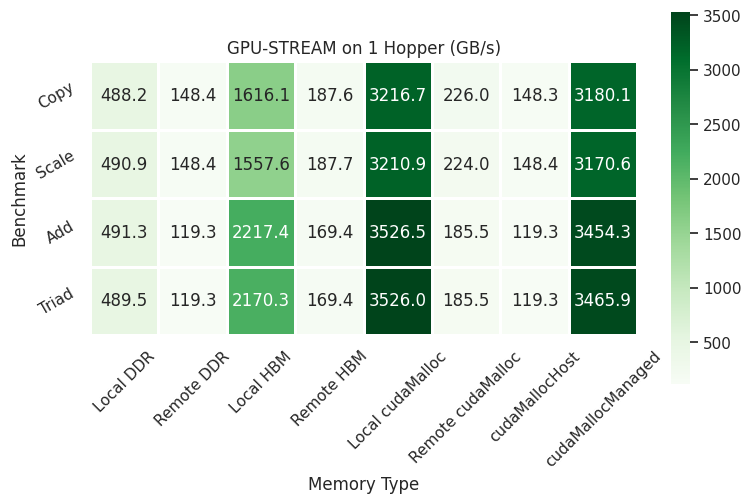

In [ ]:
data_gpu = np.array([
[488247.253, 490908.457, 491299.131, 489460.345],
[148355.744, 148438.642, 119280.010, 119279.973],
[1616059.006, 1557643.840, 2217418.248, 2170311.162],
[187596.872, 187735.020, 169388.669, 169357.428],
[3216695.560, 3210866.414, 3526534.297, 3525962.994],
[225997.111, 223977.883, 185549.324, 185525.942],
[148337.864, 148410.171, 119261.110, 119260.509], 
[3180065.094, 3170600.299, 3454279.677, 3465890.013]
]).T
data_gpu /= 1000

fig, ax2 = plt.subplots(1, 1, dpi=100, figsize=(8, 5))
sns.heatmap(data_gpu, ax=ax2, annot=True, fmt='.1f', xticklabels=labels_x + ['Local cudaMalloc', 'Remote cudaMalloc', 'cudaMallocHost', 'cudaMallocManaged'], yticklabels=labels_y, linewidths=1, square=True, cmap='Greens')
ax2.set(title="GPU-STREAM on 1 Hopper (GB/s)", xlabel="Memory Type", ylabel="Benchmark")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=30)
plt.tight_layout()
# fig, ax = plt.subplots(1, 1)

<Axes: >

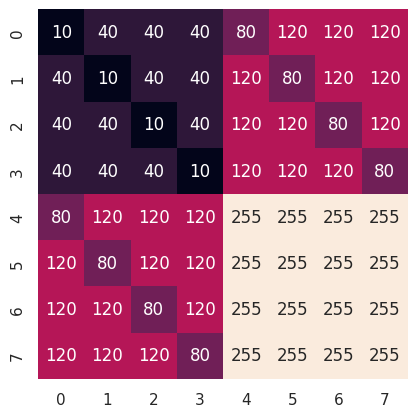

In [ ]:
numa_distances = [
    [10, 40, 40, 40, 80, 120, 120, 120],
    [40, 10, 40, 40, 120, 80, 120, 120],
    [40, 40, 10, 40, 120, 120, 80, 120],
    [40, 40, 40, 10, 120, 120, 120, 80],
    [80, 120, 120, 120, 255, 255, 255, 255],
    [120, 80, 120, 120, 255, 255, 255, 255],
    [120, 120, 80, 120, 255, 255, 255, 255],
    [120, 120, 120, 80, 255, 255, 255, 255],
]

sns.heatmap(numa_distances, annot=True, fmt='.0f', cbar=False, square=True)

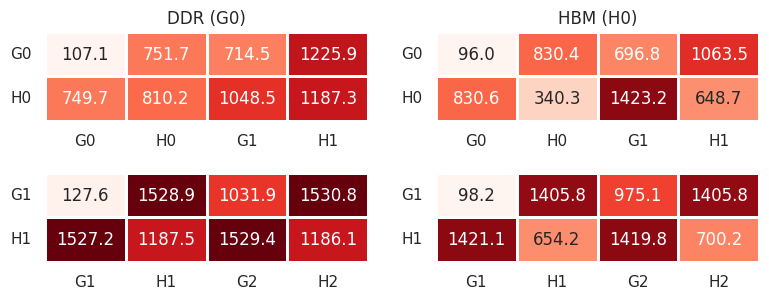

In [ ]:
dst = ['host0', 'device0', 'host1', 'device1']
labels = ['G', 'H']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=100, figsize=(8, 3))
plt.tight_layout()

def plot_heatmap(ax, src, mem, title, x, y):
    pu = ['host', 'device']
    data = np.zeros((len(pu), len(pu*2)))
    from itertools import product
    for (i, s), (j, d) in product(enumerate(pu), enumerate(pu*2)):
        data[i, j] = np.mean(get_raw_results(f'results/pingpong/{mem}/{s}{src}_{d}{src+int(j/2)}'))

    xticklabels = []
    if x:
        xticklabels = [f'{l}{src+int(i/2)}' for i, l in enumerate(labels*2)]
    yticklabels = []
    if y:
        yticklabels = [f'G{src}', f'H{src}']

    sns.heatmap(data, ax=ax, annot=True, fmt='.1f', xticklabels=xticklabels, yticklabels=yticklabels, linewidths=1, square=False, cmap='Reds', cbar=False, vmin=100, vmax=1530)
    ax.set(title=title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plot_heatmap(ax1, 0, 0, 'DDR (G0)', True, True)
plot_heatmap(ax3, 1, 0, '', True, True)

plot_heatmap(ax2, 0, 4, 'HBM (H0)', True, True)
plot_heatmap(ax4, 1, 4, '', True, True)

fig.savefig("pingpong.pdf", bbox_inches='tight')

In [ ]:
src = ['host', 'device']
dst = ['host', 'device', 'remote_host', 'remote_device']
labels = ['Grace', 'Hopper', 'Remote Grace', 'Remote Hopper']
data = np.zeros((len(src), len(dst)))

from itertools import product
for (i, s), (j, d) in product(enumerate(src), enumerate(dst)):
    data[i, j] = np.mean(get_raw_results(f'results/pingpong/{s}_{d}'))

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(4, 1))
sns.heatmap(data, ax=ax, annot=True, fmt='.1f', xticklabels=labels, yticklabels=['Grace', 'Hopper'], linewidths=1, square=False, cmap='Reds', cbar=False)
ax.set(xlabel="Pong PU", ylabel="Ping PU")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
fig.savefig("pingpong.pdf", bbox_inches='tight')

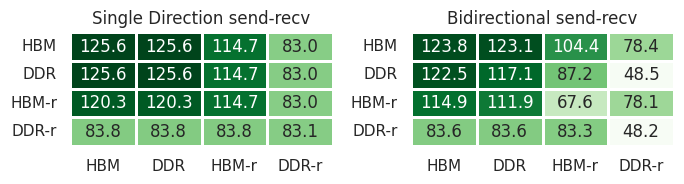

In [ ]:
memories = ['hbm', 'ddr', 'hbm_remote', 'ddr_remote']
labels = ['HBM', 'DDR', 'HBM-r', 'DDR-r']

data1 = np.zeros((len(memories), len(memories)))
data2 = np.zeros((len(memories), len(memories)))
for (i, a), (j, b) in product(enumerate(memories), enumerate(memories)):
    data1[i, j] = np.mean(get_raw_results(f'results/nccl/send_recv/local/{a}_{b}/1073741824'))
for (i, a), (j, b) in product(enumerate(memories), enumerate(memories)):
    data2[i, j] = np.mean(get_raw_results(f'results/nccl/send_recv_bi/local/{a}_{b}/1073741824'))
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(7, 2))

minval = min(np.min(data1), np.min(data2))
maxval = max(np.max(data1), np.max(data2))

ax1.set_title('Single Direction send-recv')
ax2.set_title('Bidirectional send-recv')
sns.heatmap(data1, ax=ax1, annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels, linewidths=1, square=False, cmap='Greens', cbar=False, vmin=minval, vmax=maxval)
sns.heatmap(data2, ax=ax2, annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels, linewidths=1, square=False, cmap='Greens', cbar=False, vmin=minval, vmax=maxval)
plt.tight_layout()
fig.savefig("nccl_send_recv.pdf", bbox_inches='tight')

/tmp/ipykernel_269452/2307078918.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


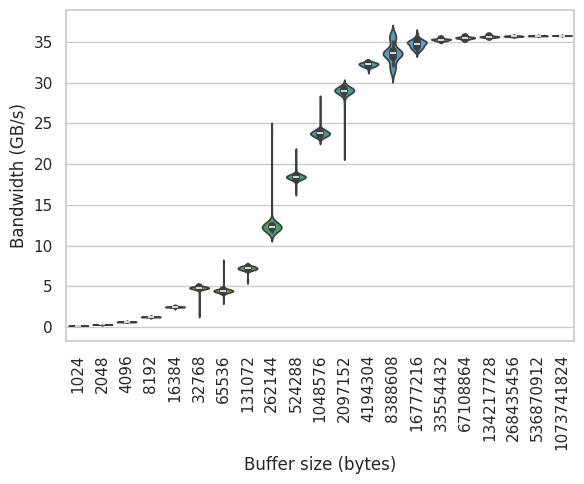

In [27]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(6, 5))
basedir = 'results/nccl/send_recv/remote/'
# basedir = 'results/nccl/all_reduce/local/'
numerical = [int(dir) for dir in os.listdir(basedir + '/ddr_ddr')]
# numerical = [int(dir) for dir in os.listdir(basedir + '/ddr')]
numerical.sort()
l = [str(i) for i in numerical]
data = {}

for i in numerical[10:]:
    with open(f'{basedir}/ddr_ddr/{i}', 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e)*(3/2) for e in elems]
        # elems.sort()
        # elems = elems[5:-5]
        data[i] = elems

# results1 = list(results_generator(l, basedir + '/hbm_hbm'))
# ax.set_xscale('log', base=2)
ax.set_xlabel('Buffer size (bytes)')
ax.set_ylabel('Bandwidth (GB/s)')
# ax.plot(numerical, results1, 'o')
sns.violinplot(data, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

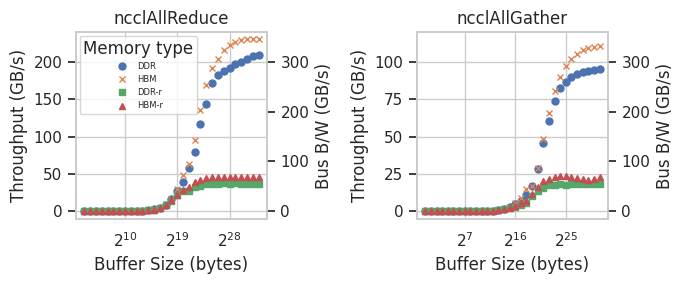

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(7, 3))
make_read_write_graph(ax1, 'results/nccl/all_reduce/local', 'ncclAllReduce', show_caches=False, remote=True, ms=5, modifier=lambda x: x)
ax12 = ax1.twinx()
ax1.set_ylim(-10, 240)
ax12.set_ylim(-10*(3/2), 240*(3/2))
ax12.grid(False)
ax12.set_ylabel('Bus B/W (GB/s)')
make_read_write_graph(ax2, 'results/nccl/all_gather/local', 'ncclAllGather', show_caches=False, remote=True, ms=5, modifier=lambda x: x, legend=False)
ax22 = ax2.twinx()
ax2.set_ylim(-5, 120)
ax22.set_ylim(-5*3, 120*3)
ax22.set_ylabel('Bus B/W (GB/s)')

ax22.grid(False)
plt.tight_layout()
fig.savefig("nccl_a2a.pdf", bbox_inches='tight')